In [ ]:
!pip install pysurvival
!pip install lifelines
!pip install osqp==0.5
!pip install scikit-survival
!pip install hyperopt
!pip install pycox
!pip install captum
!pip install shap

     |████████████████████████████████| 4.8MB 24.1MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp36-cp36m-linux_x86_64.whl size=3774946 sha256=0d0ed54230792057fad68a151206abe393e66a9c576dc240f17734243f91c622
  Stored in directory: /root/.cache/pip/wheels/6c/23/e8/6feb0c4432219666bdd5d33828d7d9f429c4726f34c6fa8061
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12076 sha256=731f51d8e02282b32e8abb05e8d14cd822f713ed1248caae859dc46e307ae071
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built pysurvival progressbar
     |████████████████████████████████| 348kB 17.4MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=f10c238b7f8d6a0b9f8cccc6214ff79c0d50e5a7eb648c64ef8995a6f749dc18
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-g

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.distributions.weibull import Weibull
from torch.distributions.log_normal import LogNormal
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily
import pandas as pd
import numpy as np
import scipy.stats as ss
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from lifelines.utils import concordance_index# as c_index
from sksurv.metrics import brier_score, integrated_brier_score, concordance_index_censored as ci_scikit
from hyperopt import hp
import hyperopt as ho
from copy import copy, deepcopy
import dask
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%pylab inline
from pysurvival.datasets import Dataset
#torch.cuda.set_device(0)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy



In [ ]:
#https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
seed = 21
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)
torch.cuda.is_available()

True

In [ ]:
df = Dataset('churn').load()
df

,product_data_storage,product_travel_expense,product_payroll,product_accounting,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,company_size,us_region,months_active,churned
0,2048,Free-Trial,Active,No,9,4,0,14,1,8.3,10-50,West North Central,3.0,1.0
1,2048,Free-Trial,Free-Trial,Active,9,4,2,12,1,0.0,100-250,South Atlantic,2.0,1.0
2,2048,Active,Active,Active,9,3,2,17,1,0.0,100-250,East South Central,7.0,0.0
3,500,Active,Free-Trial,No,10,0,0,14,0,0.0,50-100,East South Central,8.0,1.0
4,5120,Free-Trial,Active,Free-Trial,8,5,0,17,0,0.0,50-100,East North Central,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1024,Free-Trial,Active,Free-Trial,9,3,0,19,1,0.4,50-100,Mountain,8.0,0.0
1996,1024,Free-Trial,Active,Active,7,3,0,15,0,0.0,50-100,Middle Atlantic,2.0,1.0
1997,500,Free-Trial,Active,Active,8,5,0,15,0,5.9,10-50,West North Central,1.0,1.0
1998,500,Free-Trial,No,Active,10,6,1,15,1,3.3,100-250,Pacific,3.0,1.0


In [ ]:
df_info = pd.concat([df.nunique(), df.dtypes], axis=1)
df_info

,0,1
product_data_storage,6,int64
product_travel_expense,3,object
product_payroll,3,object
product_accounting,3,object
csat_score,6,int64
articles_viewed,13,int64
smartphone_notifications_viewed,4,int64
marketing_emails_clicked,20,int64
social_media_ads_viewed,3,int64
minutes_customer_support,217,float64


In [ ]:
df = df.replace({"company_size": {'self-employed': '1-1'}})
df[['min_company_size','max_company_size']] = df.company_size.str.split("-",expand=True)
df[['min_company_size','max_company_size']] = df[['min_company_size','max_company_size']].astype(float)
df['avg_company_size'] = df[['min_company_size','max_company_size']].mean(1)
df.drop(columns=['min_company_size','max_company_size', 'company_size'], inplace=True)
df

,product_data_storage,product_travel_expense,product_payroll,product_accounting,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,us_region,months_active,churned,avg_company_size
0,2048,Free-Trial,Active,No,9,4,0,14,1,8.3,West North Central,3.0,1.0,30.0
1,2048,Free-Trial,Free-Trial,Active,9,4,2,12,1,0.0,South Atlantic,2.0,1.0,175.0
2,2048,Active,Active,Active,9,3,2,17,1,0.0,East South Central,7.0,0.0,175.0
3,500,Active,Free-Trial,No,10,0,0,14,0,0.0,East South Central,8.0,1.0,75.0
4,5120,Free-Trial,Active,Free-Trial,8,5,0,17,0,0.0,East North Central,7.0,0.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1024,Free-Trial,Active,Free-Trial,9,3,0,19,1,0.4,Mountain,8.0,0.0,75.0
1996,1024,Free-Trial,Active,Active,7,3,0,15,0,0.0,Middle Atlantic,2.0,1.0,75.0
1997,500,Free-Trial,Active,Active,8,5,0,15,0,5.9,West North Central,1.0,1.0,30.0
1998,500,Free-Trial,No,Active,10,6,1,15,1,3.3,Pacific,3.0,1.0,175.0


In [ ]:
df.drop(columns=['us_region'], inplace=True)
time_column = 'months_active'
event_column = 'churned'
categorical = ['product_travel_expense', 'product_payroll', 'product_accounting']
numerical = [i for i in df.columns if i not in categorical and i != time_column and i != event_column]
 
df = pd.get_dummies(df, columns=categorical, drop_first=True)
#df = df.replace({"Attrition": {'Yes': 1, 'No': 0}})
df[time_column] = df[time_column] + 1e-5
# Extracting the features
df

,product_data_storage,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,months_active,churned,avg_company_size,product_travel_expense_Free-Trial,product_travel_expense_No,product_payroll_Free-Trial,product_payroll_No,product_accounting_Free-Trial,product_accounting_No
0,2048,9,4,0,14,1,8.3,3.00001,1.0,30.0,1,0,0,0,0,1
1,2048,9,4,2,12,1,0.0,2.00001,1.0,175.0,1,0,1,0,0,0
2,2048,9,3,2,17,1,0.0,7.00001,0.0,175.0,0,0,0,0,0,0
3,500,10,0,0,14,0,0.0,8.00001,1.0,75.0,0,0,1,0,0,1
4,5120,8,5,0,17,0,0.0,7.00001,0.0,75.0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1024,9,3,0,19,1,0.4,8.00001,0.0,75.0,1,0,0,0,1,0
1996,1024,7,3,0,15,0,0.0,2.00001,1.0,75.0,1,0,0,0,0,0
1997,500,8,5,0,15,0,5.9,1.00001,1.0,30.0,1,0,0,0,0,0
1998,500,10,6,1,15,1,3.3,3.00001,1.0,175.0,1,0,0,1,0,0


In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Heatmap(z=df[numerical].corr().values, x=numerical, y=numerical))
fig.show()

In [ ]:
from sklearn.model_selection import train_test_split

features = np.setdiff1d(df.columns, [time_column, event_column] ).tolist()
index_train, index_test = train_test_split(range(df.shape[0]), test_size=0.3, random_state=0, stratify=df[event_column])

tmp_data_train = df.loc[index_train].reset_index( drop = True )
data_test  = df.loc[index_test].reset_index( drop = True )

index_train, index_valid = train_test_split(tmp_data_train.index, test_size=0.1, random_state=0, stratify=tmp_data_train[event_column])
data_train = tmp_data_train.loc[index_train].reset_index( drop = True )
data_valid = tmp_data_train.loc[index_valid].reset_index( drop = True )

 
# Creating the X, T and E inputs
X_train, X_valid, X_test = data_train[features], data_valid[features], data_test[features]
T_train, T_valid, T_test = data_train[time_column], data_valid[time_column], data_test[time_column]
E_train, E_valid, E_test = data_train[event_column], data_valid[event_column], data_test[event_column]
 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(X_train[numerical])
scaled_valid = scaler.transform(X_valid[numerical])
scaled_test = scaler.transform(X_test[numerical])
X_train[numerical], X_valid[numerical], X_test[numerical] = scaled_train, scaled_valid, scaled_test

X_train.shape, X_valid.shape, X_test.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



((1260, 14), (140, 14), (600, 14))

In [ ]:
from torch import autograd
 
class NNModel(nn.Module):
    def __init__(self, input_shape, units=None, factors=None, dropout=None, slops=None):
        super().__init__()
        self.input_shape = input_shape
        self.units = units
        self.factors = factors
        self.network = nn.ModuleList()
        if self.factors:
            self.units = np.round(self.input_shape * np.asarray(self.factors)).astype(int)
        if self.units is not None:
            self.dropout = np.zeros_like(self.units) if dropout is None else dropout
            self.slops = np.full(len(self.units), 1.) if slops is None else slops
            for i, j, k in zip(self.units, self.dropout, self.slops):
                if i >= 1:
                    block = self.__build_block__(input_shape, i, p=j, slop=k)
                    self.network.extend(block)
                    input_shape = i
        self.output_shape = input_shape
        self.reset_parameters()
    
    def __build_block__(self, input_shape, units, p, slop, norm=True):
        block = []
        block.append(nn.Linear(input_shape, units, bias=True).double())
        if norm:
            #block.append(nn.BatchNorm1d(units).double())
            block.append(nn.LayerNorm(units, eps=1e-5).double())
        block.append(nn.ELU(slop))
        if p > 0:
            block.append(nn.Dropout(p))
        return block
 
    def forward(self, x):
        for layer in self.network:
          tmp = layer(x)
          x = tmp
        return x
 
    def reset_parameters(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                layer.bias.data.fill_(0.1)
 
    def get_weight(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                print('MAX WEIGHT = ', layer.weight.max())
                print('MIN WEIGHT = ', layer.weight.min())
 
    def get_grad(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                print('MAX GRAD = ', layer.weight.grad.max())
                print('MIN GRAD = ', layer.weight.grad.min())
 
 
class DenseBlock(nn.Module):
    def __init__(self, input_shape, nb_block, growth_rate, units, factors=None, dropout=0., slops=1.):
        super(DenseBlock, self).__init__()
        self.dropout = [dropout for i in range(nb_block)]
        self.slops = [slops for i in range(nb_block)]
        self.growth_rate = growth_rate
        self.network = nn.ModuleList()
        for j, k, l in zip(self.dropout, self.slops, range(nb_block)):
            block = NNModel(input_shape, units=[units], factors=factors, dropout=[j], slops=[k])
            self.network.extend([block])
            input_shape += units
            units += growth_rate
        self.input_shape = input_shape
        self.output_shape = units
 
    def forward(self, input):
        for block in self.network:
            x = block(input)
            input = torch.cat((input, x), 1)
        return input
 
class DenseNet(nn.Module):
    def __init__(self, input_layer, dense_blocks):
        super(DenseNet, self).__init__()
        self.input_layer = input_layer
        self.network = nn.ModuleList()
        self.network.extend(dense_blocks)
        self.output_shape = dense_blocks[-1].output_shape
 
    def forward(self, input):
        input = self.input_layer(input) if self.input_layer else input
        for i in self.network:
            input = i(input)
        return input
 
 
 
class CENSORED_SURV_DATA(Dataset):
    def __init__(self, X_cens, T_cens):
        self.X_cens, self.T_cens = X_cens.astype(np.float64), T_cens.astype(np.float64)
 
    def __len__(self):
        return len(self.X_cens)
 
    def __getitem__(self, idx):
        return self.X_cens[idx], self.T_cens[idx]
 
class UNCENSORED_SURV_DATA(Dataset):
    def __init__(self, X_uncens, T_uncens):
        self.X_uncens, self.T_uncens = X_uncens.astype(np.float64), T_uncens.astype(np.float64)
 
    def __len__(self):
        return len(self.X_uncens)
 
    def __getitem__(self, idx):
        return self.X_uncens[idx], self.T_uncens[idx]
 
class MWN(nn.Module):
    def __init__(self, shared, clf_nn, alpha_nn, beta_nn, n_comp):
        super(MWN, self).__init__()
        self.shared = shared
        self.clf_nn = clf_nn
        self.alpha_nn = alpha_nn
        self.beta_nn = beta_nn
        self.n_comp = n_comp
        self.pi = nn.Linear(self.clf_nn.output_shape, self.n_comp).double() if self.n_comp > 1 else None
        self.ai = nn.Linear(self.alpha_nn.output_shape, self.n_comp).double()
        self.bi = nn.Linear(self.beta_nn.output_shape, self.n_comp).double()
 
    def forward(self, x):
        x = self.shared(x)
        proba = self.proba_model(x) if self.n_comp > 1 else torch.ones((len(x),1))
        alpha = self.alpha_model(x)
        beta = self.beta_model(x)
        return proba, beta, alpha
 
    def proba_model(self, x):
        model = self.clf_nn(x)
        model = self.pi(model)
        model = nn.Softmax(dim=-1)(model)
        return model
 
    def alpha_model(self, x):
        model = self.alpha_nn(x)
        model = self.ai(model)
        model = nn.ELU()(model) + 1 + 1e-5 #WEIBULL
        return model
 
    def beta_model(self, x):
        model = self.beta_nn(x)
        model = self.bi(model)
        model = nn.ELU()(model) + 2 #WEIBULL
        #model = nn.ELU()(model) + 1 + 1e-5 #LOGNORMAL
        return model
 
    def get_grad(self):
        self.shared.get_grad()
        self.clf_nn.get_grad()
        self.alpha_nn.get_grad()
        self.beta_nn.get_grad()
        print('MAX GRAD = ', self.pi.weight.grad.max())
        print('MAX GRAD = ', self.ai.weight.grad.max())
        print('MAX GRAD = ', self.bi.weight.grad.max())
 
    def get_weight(self):
        self.shared.get_weight()
        self.clf_nn.get_weight()
        self.alpha_nn.get_weight()
        self.beta_nn.get_weight()
        print('MAX WEIGHT = ', self.pi.weight.max())
        print('MIN WEIGHT = ', self.pi.weight.min())
        print('MAX WEIGHT = ', self.ai.weight.max())
        print('MIN WEIGHT = ', self.ai.weight.min())
        print('MAX WEIGHT = ', self.bi.weight.max())
        print('MIN WEIGHT = ', self.bi.weight.min())
        print('DTYPE = ', self.bi.weight.dtype)
 
class DeepWeiSurv:
    def __init__(self, model, num_time_bins, resume=None):
        self.model = model
        self.losses = {'Epoch': [], 'Train': [], 'Test': [], 'State': [], 'LR': []}
        self.num_time_bins = num_time_bins
        self.times = None
        self.optim = resume
 
    def process_data(self, data, time, event):
        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []
        T_cens, T_uncens = [], []
        for i, e in enumerate(event):
            if e == 1: #not censored              
                X_uncens.append(data[i,:]), Y_uncens.append(e), T_uncens.append(time[i])
            else:
                X_cens.append(data[i,:]), Y_cens.append(e), T_cens.append(time[i])
        return np.asarray(X_uncens), np.asarray(Y_uncens), np.asarray(T_uncens), np.asarray(X_cens), np.asarray(Y_cens), np.asarray(T_cens)
 
    def loss_function(self, X_uncens, T_uncens, X_cens, T_cens, l2_reg):
        pi, beta, alpha = self.model(X_uncens)
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)#LogNormal(alpha, beta, validate_args=None)#
        pdf = MixtureSameFamily(mix, comp).log_prob(T_uncens)
        ll1 = torch.mean(pdf)
        #print('ll1 = ', ll1)
        pi_u, beta_u, alpha_u = self.model(X_cens)
        mix_u = Categorical(pi_u)
        comp_u = Weibull(alpha_u, beta_u, validate_args=None)#LogNormal(alpha_u, beta_u, validate_args=None)#
        surv = torch.clamp(1 - MixtureSameFamily(mix_u, comp_u).cdf(T_cens), min=1e-10)
        ll2 = torch.mean(torch.log(surv))
        #print('ll2 = ', ll2)
        loss = -(ll1 + ll2)
        return loss
 
    def train_model(self, optim, uncens_train_load, cens_train_load, grad_clip, l2_reg):
          total_loss = 0
          self.model = self.model.train()
        #with autograd.detect_anomaly():
          for i, (uncens, cens) in enumerate(zip(uncens_train_load, cens_train_load)):
              #self.model.get_weight()
              X_uncens, T_uncens = uncens
              X_cens, T_cens = cens
              self.optim.zero_grad()
              loss = self.loss_function(X_uncens, T_uncens, X_cens, T_cens, l2_reg)
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
              self.optim.step()
              '''self.model.get_grad()
              print('_'*50)'''
              total_loss += loss.item()
          return total_loss/(i+1)#np.abs(-100. - total_loss)#criterion(total_loss/(i+1), torch.tensor([-100]))
        
 
    def eval_model(self, uncens_test_load, cens_test_load):
        self.model = self.model.eval()
        total_loss = 0
        for i, (uncens, cens) in enumerate(zip(uncens_test_load, cens_test_load)):
            X_uncens, T_uncens = uncens
            X_cens, T_cens = cens
            loss = self.loss_function(X_uncens, T_uncens, X_cens, T_cens, l2_reg=0)
            total_loss += loss.item()
        return total_loss/(i+1)#np.abs(-100. - total_loss)
 
    def lr_finder(self, X_train, T_train, E_train, min_lr, max_lr, batch_size=None,  grad_clip=100, momentum=0.9, is_min_time_zero=False, extra_pct_time=0.1, 
                  l2_reg=0):
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins)
 
        batch_size = len(X_train) if batch_size is None else batch_size
        X_train_uncens, Y_train_uncens, T_train_uncens, X_train_cens, Y_train_cens, T_train_cens = self.process_data(X_train, T_train, E_train)
        uncens_train_load = DataLoader(UNCENSORED_SURV_DATA(X_train_uncens, T_train_uncens), batch_size=batch_size, shuffle=False)  # DATALOADER obj
        cens_train_load = DataLoader(CENSORED_SURV_DATA(X_train_cens, T_train_cens), batch_size=batch_size, shuffle=False)  # DATALOADER obj
        self.optim = opt.SGD(self.model.parameters(), lr=min_lr, momentum=momentum, nesterov=True, weight_decay=l2_reg)
        scheduler = opt.lr_scheduler.StepLR(self.optim, step_size=1, gamma=2)
        lr, loss = [], []
        curr_lr = min_lr
        while curr_lr<max_lr:
            train_loss = self.train_model(self.optim, uncens_train_load, cens_train_load, grad_clip, l2_reg)
            scheduler.step()
            curr_lr = scheduler.get_last_lr()[0]
            lr.append(curr_lr), loss.append(train_loss)
        return lr, loss
 
    def fit(self, X_train, T_train, E_train, epoch, lr, opt_kwarg, batch_size=None,  grad_clip=100, momentum=0.9, is_min_time_zero=False, extra_pct_time=0.1,
            X_test=None, T_test=None, E_test=None, l2_reg=0, eval=True, verbose=True, save=True):
        
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins)
 
        batch_size = len(X_train) if batch_size is None else batch_size
        X_train_uncens, Y_train_uncens, T_train_uncens, X_train_cens, Y_train_cens, T_train_cens = self.process_data(X_train, T_train, E_train)
        uncens_train_load = DataLoader(UNCENSORED_SURV_DATA(X_train_uncens, T_train_uncens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        cens_train_load = DataLoader(CENSORED_SURV_DATA(X_train_cens, T_train_cens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        if X_test is not None:
            X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)
            uncens_test_load = DataLoader(UNCENSORED_SURV_DATA(X_test_uncens, T_test_uncens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
            cens_test_load = DataLoader(CENSORED_SURV_DATA(X_test_cens, T_test_cens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
 
        best_loss = 1e100
        #self.optim = opt.Adam(self.model.parameters(), lr=lr)
        self.optim = opt.SGD(self.model.parameters(), lr=lr, momentum=momentum, nesterov=True, weight_decay=l2_reg)

        #scheduler = None
        scheduler = opt.lr_scheduler.CyclicLR(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.ReduceLROnPlateau(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.MultiStepLR(self.optim, milestones=[28, 120], gamma=0.1)
 
        eval_score = ''
        for i in range(epoch):
            if verbose:
              print('##### EPOCH '+str(i) + ' #####')
            train_loss = self.train_model(self.optim, uncens_train_load, cens_train_load, grad_clip, l2_reg)
            
            if np.isnan(train_loss) or np.isinf(train_loss):
                print('Stop training')
                break
            if verbose:
              print('train loss : ' ,train_loss)
 
            '''if train_loss < 11 :
                for g in optim.param_groups:
                    g['lr'] = g['lr'] * 0.01
            print(optim.param_groups[0]['lr'])'''
 
            self.losses['Epoch'].append(i), self.losses['Train'].append(train_loss)
            
            if X_test is not None:
                test_loss = self.eval_model(uncens_test_load, cens_test_load)
                #metric = self.c_index(X_test, T_test, E_test)
                if eval:
                    _, eval_score = self.b_index(X_train, T_train, E_train, X_test, T_test, E_test, plot=False)
                if save and (test_loss<best_loss):
                    self.losses['State'] = deepcopy(self.model.state_dict())
                    best_loss = test_loss
                    if verbose:
                      print('===========SAVE===========')
 
                if verbose:
                      print('test loss : ' ,test_loss, ' _______ Metric : ', eval_score)
 
                self.losses['Test'].append(test_loss)
                if scheduler is not None:
                    '''scheduler.step(test_loss)
                    self.losses['LR'].append(self.optim.param_groups[0]['lr'])'''
                    scheduler.step()
                    self.losses['LR'].append(scheduler.get_last_lr()[0])
                    
 
 
    def prdict_survival(self, X):
        X = torch.tensor(X.astype(np.float64))
        T = torch.FloatTensor(self.times[:,np.newaxis,np.newaxis])
        pi, beta, alpha = self.model(X)
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)#LogNormal(alpha, beta, validate_args=None)#
        surv = 1 - MixtureSameFamily(mix, comp).cdf(T)
        return pi, beta, alpha, surv
 
    def c_index(self, p, alpha, beta, t, e):
        mlt = torch.sum(pi * alpha * torch.lgamma(1 + (1/beta)).exp(), 1).data.numpy() #WEIBULL
        #mlt = torch.sum(pi * torch.exp(alpha + torch.pow(beta, 2)/2), 1).data.numpy() #LOGNORMAL
        res = 1 - ci_scikit(e.astype(np.bool), t, mlt)[0]
        return mlt, res
 
    def b_index(self, X_train, T_train, E_train, X_test, T_test, E_test, survival, plot=True):
        time_idx = self.times[np.argmin(self.times<min(T_test)):np.argmax(self.times>max(T_test)) - 1] #don't keep times index that are beyond max(T_train)
        train_e_t = np.asarray(list(zip(E_train.astype(np.bool), T_train)), dtype='|bool, i4') #concat event and time
        test_e_t = np.asarray(list(zip(E_test.astype(np.bool), T_test)), dtype='|bool, i4')
        brier_res = []
        for j, i in enumerate(time_idx):
            _, score = brier_score(train_e_t, test_e_t, survival[:,j], i)
            brier_res.append(score[0])
        ibs = np.trapz(brier_res, time_idx)/max(T_train)
        if plot:
            figure = self.plot_brier_curve(time_idx, brier_res, ibs)
            return brier_res, ibs, figure
        else:
            return brier_res, ibs
 
    def plot_brier_curve(self, time_axis, score, ibs):
        fig, ax = plt.subplots(figsize=(8, 4))
        plt.plot(time_axis, score, color='blue', label='Brier score / time', lw=2)
 
        plt.axhline(y=0.25, color='black', linestyle='-')
        #ax.annotate('0.25', xy=(1, 0.5), xytext=(t, 0.5), fontsize=12)
 
        title = "Integrated Brier Score: " + str(ibs)
        plt.legend(fontsize=12)
        plt.title(title, fontsize=15)
        plt.ylim(0, 1.05)
        return plt

    def feature_importance(self, rep, X_test, T_test, E_test, batch_size=None):
        res = np.zeros((rep, X_test.shape[1]))
        batch_size = len(X_train) if batch_size is None else batch_size
        X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)
        uncens_test_load = DataLoader(UNCENSORED_SURV_DATA(X_test_uncens, T_test_uncens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        cens_test_load = DataLoader(CENSORED_SURV_DATA(X_test_cens, T_test_cens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        base_loss = self.eval_model(uncens_test_load, cens_test_load)
        origin = X_test.copy()
        for i in range(X_test.shape[1]):
            for j in range(rep):
                X_test[:,i] = np.random.permutation(X_test[:,i])
                X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)
                uncens_test_load = DataLoader(UNCENSORED_SURV_DATA(X_test_uncens, T_test_uncens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
                cens_test_load = DataLoader(CENSORED_SURV_DATA(X_test_cens, T_test_cens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
                loss = self.eval_model(uncens_test_load, cens_test_load)
                res[j, i] = base_loss - loss
                X_test = origin
        res = np.abs(res)
        return {'importances': res, 'importances_mean': np.mean(res, 0), 'importances_std': np.std(res, 0)}
 
def gradient_clipper(model: nn.Module, val: float) -> nn.Module:
    def process_grad(grad):
        grad[grad != grad] = 1e-10
        return torch.clamp(grad, -val, val)
    for parameter in model.parameters():
        parameter.register_hook(lambda grad: process_grad(grad))
    
    return model

In [ ]:
n_comp, epoch, lr, batch_size, d = 1, 25000, 1e-4, None, 0.8

shared_nn = NNModel(X_train.shape[1], units=[70, 110, 130, 150], factors=None, dropout=[d,d,d,d])
clf_nn = NNModel(shared_nn.output_shape + X_train.shape[1], units=[1], factors=None, dropout=None)
alpha_nn = NNModel(shared_nn.output_shape + X_train.shape[1], units=[130, 80, 60], factors=None, dropout=[d,d,d])
beta_nn = NNModel(shared_nn.output_shape + X_train.shape[1], units=[130, 80, 60], factors=None, dropout=[d,d,d])#, dropout=[d,d,d,d]
nn_model = MWN(shared_nn, None, alpha_nn, beta_nn, n_comp)
dws = DeepWeiSurv(nn_model, 100)
lr, loss = dws.lr_finder(X_train.values, T_train.values, E_train.values, 1e-5, 0.01, batch_size=batch_size)

fig = go.Figure(data=go.Scatter(x=lr, y=loss, mode='lines+markers'))
fig.show()

In [ ]:
n_comp, epoch, lr, batch_size, d = 2, 50000, 0.001, 512, 0.5
cyclic_kwarg = {'base_lr': lr, 'max_lr': 0.1, 'step_size_up':1000, 'step_size_down':1000}
#plateau_kwarg = {'factor':0.5, 'patience':200, 'verbose':True, 'min_lr':0.005, 'mode':'min'}

shared_nn = NNModel(X_train.shape[1], units=[70, 110, 150], factors=None, dropout=[d,d,d])
clf_nn = NNModel(shared_nn.output_shape , units=[90], factors=None, dropout=[d])
alpha_nn = NNModel(shared_nn.output_shape, units=[90], factors=None, dropout=[d])
beta_nn = NNModel(shared_nn.output_shape, units=[90], factors=None, dropout=[d])#, dropout=[d,d,d,d]

nn_model = gradient_clipper(MWN(shared_nn, clf_nn, alpha_nn, beta_nn, n_comp), 100)
#nn_model.load_state_dict(best_state)
print(nn_model)
dws = DeepWeiSurv(nn_model, 20)
dws.fit(X_train.values, T_train.values, E_train.values, epoch, lr, cyclic_kwarg, batch_size=batch_size, grad_clip=10, momentum=0.9,
        X_test=X_valid.values, T_test=T_valid.values, E_test=E_valid.values, l2_reg=0, eval=False, verbose=True, is_min_time_zero=True)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
##### EPOCH 30125 #####
train loss :  1.1037011895445574
test loss :  1.6974061943029002  _______ Metric :  
##### EPOCH 30126 #####
train loss :  1.214520976926098
test loss :  1.6843209177481095  _______ Metric :  
##### EPOCH 30127 #####
train loss :  1.2483279936244114
test loss :  1.6797261080225319  _______ Metric :  
##### EPOCH 30128 #####
train loss :  1.1656563958852448
test loss :  1.6776577232202963  _______ Metric :  
##### EPOCH 30129 #####
train loss :  1.214019314445586
test loss :  1.673327889123259  _______ Metric :  
##### EPOCH 30130 #####
train loss :  1.2130432633094632
test loss :  1.6659776155933679  _______ Metric :  
##### EPOCH 30131 #####
train loss :  1.2654870662930362
test loss :  1.6540031947923985  _______ Metric :  
##### EPOCH 30132 #####
train loss :  1.1791748666189403
test loss :  1.6441733440663064  _______ Metric :  
##### EPOCH 30133 #####
train loss :  1.2511535345419

KeyboardInterrupt: ignored

In [ ]:
#dws.losses['State'][-2]
best_state = deepcopy(dws.losses['State'])
dws.model.load_state_dict(best_state), np.min(dws.losses['Test'])

(<All keys matched successfully>, 1.2739612470531783)

In [ ]:
pi, beta, alpha, survival_predictions = dws.prdict_survival(X_test.values)
survival_predictions = np.squeeze(survival_predictions.data.numpy())
survival_predictions.shape

(20, 600)

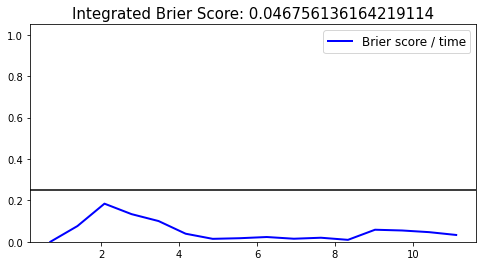

0.8637153374233129


In [ ]:
brier_res, ibs, figure = dws.b_index(X_train.values, T_train, E_train, X_test.values, T_test, E_test, survival_predictions.T, plot=True)
figure.show()
mlt, c_index = dws.c_index(pi, alpha, beta, T_test, E_test)
print(c_index)

In [ ]:
kfolds = 2
num_time_bins, epoch, batch_size = 100, 2000, None
n_comp = 1

def generate_data(data_train, seed): #those are copies
    tmp_data_train = data_train.copy()
    index_train, index_valid = train_test_split(tmp_data_train.index, test_size=0.2, stratify=tmp_data_train[event_column], random_state=seed)
    data_train = tmp_data_train.loc[index_train].reset_index( drop = True )
    data_valid = tmp_data_train.loc[index_valid].reset_index( drop = True )

    X_train, X_valid = data_train[features], data_valid[features]
    T_train, T_valid = data_train[time_column], data_valid[time_column]
    E_train, E_valid = data_train[event_column], data_valid[event_column]
    return X_train, X_valid, T_train, T_valid, E_train, E_valid

    

def _cross_val_(model, data_train, lr, opt_kwarg, momentum=0.9, l2=1e-2, smooth=1e-2, seed=None):
    X_train, X_valid, T_train, T_valid, E_train, E_valid = generate_data(data_train, seed)
    model.fit(X_train.values, T_train.values, E_train.values, epoch, lr, opt_kwarg, batch_size=batch_size, grad_clip=10, momentum=momentum,
        X_test=X_valid.values, T_test=T_valid.values, E_test=E_valid.values, l2_reg=l2, eval=False, verbose=False, is_min_time_zero=True, save=False)
    
    val_loss = np.min(model.losses['Test']) if len(model.losses['Test']) >= 1 else 1e100
    return val_loss

def cross_val(space):
    print(space)
    res = []
    shared_factors = [space[k] for k in ['shared_l1','shared_l2','shared_l3','shared_l4']]
    clf_factors = [space[k] for k in ['clf_l1', 'clf_l2']]
    alpha_factors = [space[k] for k in ['alpha_l1', 'alpha_l2']]
    beta_factors = [space[k] for k in ['beta_l1', 'beta_l2']]
    #dropout = [space[k] for k in ['d1','d2','d3','d4']]
    #slops = [space[k] for k in ['s1','s2','s3','s4']]
    opt_kwarg = {'base_lr': space['lr'], 'max_lr': space['max_lr'], 'step_size_up':int(space['step_size']), 'step_size_down':int(space['step_size'])}
    for i in range(kfolds):
        shared_nn = NNModel(X_train.shape[1], units=None, factors=shared_factors, dropout=None)
        clf_nn = NNModel(shared_nn.output_shape + X_train.shape[1], units=None, factors=clf_factors, dropout=None)
        alpha_nn = NNModel(shared_nn.output_shape + X_train.shape[1], units=None, factors=alpha_factors, dropout=None)
        beta_nn = NNModel(shared_nn.output_shape + X_train.shape[1], units=None, factors=beta_factors, dropout=None)#, dropout=[d,d,d,d]
        nn_model = MWN(shared_nn, clf_nn, alpha_nn, beta_nn, n_comp)
        dws = DeepWeiSurv(nn_model, num_time_bins)
        val_loss = dask.delayed(_cross_val_)(dws, data_train, space['lr'], opt_kwarg, seed=i)
        res.append(val_loss)
    res = dask.compute(res)
    print(res)
    print('______________')
    return np.mean(res)

layer_lb, layer_ub, dropout_lb, dropout_ub, slope_lb, slope_ub,  = 0, 10, 0, 1, 1e-6, 10
lr_lb, lr_ub, mom_lb, mom_ub = 1e-7, 1e-5, 1e-5, 0.999
max_lr_lb, max_lr_ub, step_size_lb, step_size_ub = 1e-3, 1e-2, 500, 500
#factor_lb, factor_ub, patience_lb, patience_ub = 1e-5, 0.999, 5, 30
#l2_lb, l2_ub, smooth_lb, smooth_ub = 1e-5, 0.999, 1e-5, 0.999

space = {
    "shared_l1": hp.uniform("shared_l1", layer_lb, layer_ub),
    "shared_l2": hp.uniform("shared_l2", layer_lb, layer_ub),
    "shared_l3": hp.uniform("shared_l3", layer_lb, layer_ub),
    "shared_l4": hp.uniform("shared_l4", layer_lb, layer_ub),

    "clf_l1": hp.uniform("clf_l1", layer_lb, layer_ub),
    "clf_l2": hp.uniform("clf_l2", layer_lb, layer_ub),

    "alpha_l1": hp.uniform("alpha_l1", layer_lb, layer_ub),
    "alpha_l2": hp.uniform("alpha_l2", layer_lb, layer_ub),

    "beta_l1": hp.uniform("beta_l1", layer_lb, layer_ub),
    "beta_l2": hp.uniform("beta_l2", layer_lb, layer_ub),

    "lr": hp.uniform("lr", lr_lb, lr_ub),
    "max_lr": hp.uniform("max_lr", max_lr_lb, max_lr_ub),
    "step_size": hp.uniform("step_size", step_size_lb, step_size_ub),
    }

tpe_algo = ho.tpe.suggest
tpe_trials = ho.Trials()
tpe_best = ho.fmin(fn=cross_val, space=space, algo=tpe_algo, trials=tpe_trials, max_evals=1000,)
print(tpe_best)

In [ ]:
class LRMultiTask(nn.Module):
    def __init__(self, input_size, num_time_bins):
        super().__init__()
        self.input_size, self.num_time_bins = input_size, num_time_bins
        self.fc = torch.nn.Linear(self.input_size, self.num_time_bins - 1).double()
        self.reset_parameters()
 
    def forward(self, x):
        out = self.fc(x)
        return out
 
    def reset_parameters(self):
        self.fc.weight = nn.init.xavier_normal_(self.fc.weight)
        self.fc.bias = nn.init.constant_(self.fc.bias, 0.001)
  
class NN_Multi_Task(nn.Module):
    def __init__(self, input_shape, num_time_bins, units=None, factors=None, dropout=None):
        super(NN_Multi_Task, self).__init__()
        self.nn_model = NNModel(input_shape, units, factors, dropout)
        self.mtlr = LRMultiTask(self.nn_model.units[-1], num_time_bins)
 
    def forward(self, x):
        x = self.nn_model(x)
        x = self.mtlr(x)
        return x
 
class MTLR():
    def __init__(self, model, input_size, num_time_bins):
        self.input_size, self.num_time_bins = input_size, num_time_bins
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model#.to(self.device) #builded model
        self.triangle = torch.FloatTensor(np.tri(self.num_time_bins - 1, self.num_time_bins, dtype=np.float64)).double()
        self.times = None
        self.losses = {'Epoch': [], 'Train': [], 'Test': [], 'State': [], 'LR': []}
        self.optim = None
 
    def process_data(self, data, time, event):
        bin_idxs = np.digitize(time, self.times)
        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []
        for i, e in enumerate(event):
            bin_idx = bin_idxs[i]
            tmp = np.zeros((self.num_time_bins))
            if e == 1: #not censored              
                tmp[bin_idx] = 1
                X_uncens.append(data[i,:]), Y_uncens.append(tmp)
            else:
                tmp[bin_idx:] = 1
                X_cens.append(data[i,:]), Y_cens.append(tmp)
        return np.asarray(X_uncens), np.asarray(Y_uncens), np.asarray(X_cens), np.asarray(Y_cens)
 
    def norm_diff(self, W):
            """ Special norm function for the last layer of the MTLR """
            dims=len(W.shape)
            if dims==1:
                diff = W[1:]-W[:-1]
            elif dims==2:
                diff = W[1:, :]-W[:-1, :]
            return torch.sum(diff*diff)
 
    def loss_function(self, X_cens, X_uncens, Y_cens, Y_uncens, l2_reg, l2_smooth):
        
        # Likelihood Calculations -- Uncensored
        score_uncens = self.model(X_uncens)
        phi_uncens = torch.exp( torch.mm(score_uncens, self.triangle) )
        reduc_phi_uncens = torch.sum(phi_uncens*Y_uncens, dim = 1)
 
        # Likelihood Calculations -- Censored
        score_cens = self.model(X_cens)
        phi_cens = torch.exp( torch.mm(score_cens, self.triangle) )
        reduc_phi_cens = torch.sum( phi_cens*Y_cens, dim = 1)
 
        # Likelihood Calculations -- Normalization
        z_uncens = torch.exp( torch.mm(score_uncens, self.triangle) )
        reduc_z_uncens = torch.sum( z_uncens, dim = 1)
 
        z_cens = torch.exp( torch.mm(score_cens, self.triangle) )
        reduc_z_cens = torch.sum( z_cens, dim = 1)
 
        # MTLR cost function
        loss = - (
                    torch.sum( torch.log(reduc_phi_uncens) ) \
                  + torch.sum( torch.log(reduc_phi_cens) )  \
 
                  - torch.sum( torch.log(reduc_z_uncens) ) \
                  - torch.sum( torch.log(reduc_z_cens) ) 
                 )
 
        # Adding the regularized loss
        nb_set_parameters = len(list(self.model.parameters()))
        for i, w in enumerate(self.model.parameters()):            
            if i >= nb_set_parameters - 2:
                loss += l2_smooth*self.norm_diff(w)
                
        return loss
 
    def train_model(self, optim, uncens_train_load, cens_train_load, grad_clip, l2_reg, l2_smooth):
          total_loss = 0
          self.model = self.model.train()
        #with autograd.detect_anomaly():
          for i, (uncens, cens) in enumerate(zip(uncens_train_load, cens_train_load)):
              #self.model.get_weight()
              X_uncens, Y_uncens = uncens
              X_cens, Y_cens = cens
              self.optim.zero_grad()
              loss = self.loss_function(X_cens, X_uncens, Y_cens, Y_uncens, l2_reg, l2_smooth)
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
              self.optim.step()
              '''self.model.get_grad()
              print('_'*50)'''
              total_loss += loss.item()
          return total_loss/(i+1)
        
 
    def eval_model(self, uncens_test_load, cens_test_load, l2_reg, l2_smooth):
        self.model = self.model.eval()
        total_loss = 0
        for i, (uncens, cens) in enumerate(zip(uncens_test_load, cens_test_load)):
            X_uncens, Y_uncens = uncens
            X_cens, Y_cens = cens
            loss = self.loss_function(X_cens, X_uncens, Y_cens, Y_uncens, l2_reg, l2_smooth)
            total_loss += loss.item()
        return total_loss/(i+1)#np.abs(-100. - total_loss)
 
    def fit(self, X_train, T_train, E_train, epoch, lr, opt_kwarg, batch_size=None,  grad_clip=100, momentum=0.9, is_min_time_zero=False, extra_pct_time=0.1,
            X_test=None, T_test=None, E_test=None, l2_reg=1e-2, l2_smooth=1e-2, eval=True, verbose=True, save=True):
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins)
        X_train_uncens, Y_train_uncens, X_train_cens, Y_train_cens = self.process_data(X_train, T_train, E_train)
        uncens_train_load = DataLoader(UNCENSORED_SURV_DATA(X_train_uncens, Y_train_uncens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        cens_train_load = DataLoader(CENSORED_SURV_DATA(X_train_cens, Y_train_cens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        if X_test is not None:
            X_test_uncens, Y_test_uncens, X_test_cens, Y_test_cens = self.process_data(X_test, T_test, E_test)
            uncens_test_load = DataLoader(UNCENSORED_SURV_DATA(X_test_uncens, Y_test_uncens), batch_size=batch_size, shuffle=True)  # DATALOADER obj
            cens_test_load = DataLoader(CENSORED_SURV_DATA(X_test_cens, Y_test_cens), batch_size=batch_size, shuffle=True)  # DATALOADER obj

        #optim = opt.Adam(self.model.parameters(), lr=lr)
        self.optim = opt.SGD(self.model.parameters(), lr=lr, momentum=momentum, nesterov=True, weight_decay=l2_reg)
        #scheduler = opt.lr_scheduler.CyclicLR(self.optim, **opt_kwarg)
        scheduler = opt.lr_scheduler.ReduceLROnPlateau(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.MultiStepLR(self.optim, milestones=[28, 120], gamma=0.1)

        eval_score, best_loss = '', 1e100
        for i in range(epoch):
            if verbose:
              print('##### EPOCH '+str(i) + ' #####')
            train_loss = self.train_model(self.optim, uncens_train_load, cens_train_load, grad_clip, l2_reg, l2_smooth)
            
            if np.isnan(train_loss) or np.isinf(train_loss):
                print('Stop training')
                break
            if verbose:
              print('train loss : ' ,train_loss)
 
            '''if train_loss < 11 :
                for g in optim.param_groups:
                    g['lr'] = g['lr'] * 0.01
            print(optim.param_groups[0]['lr'])'''
 
            self.losses['Epoch'].append(i), self.losses['Train'].append(train_loss)
            
            if X_test is not None:
                test_loss = self.eval_model(uncens_test_load, cens_test_load, l2_reg, l2_smooth)
                
                #metric = self.c_index(X_test, T_test, E_test)
                if eval:
                    _, eval_score = self.b_index(X_train, T_train, E_train, X_test, T_test, E_test, plot=False)
                if save and (test_loss<best_loss):
                    self.losses['State'] = deepcopy(self.model.state_dict())
                    best_loss = test_loss
                    if verbose:
                      print('===========SAVE===========')
 
                if verbose:
                      print('test loss : ' ,test_loss, ' _______ Metric : ', eval_score)
 
                self.losses['Test'].append(test_loss)
                if scheduler is not None:
                    scheduler.step(test_loss)
                    self.losses['LR'].append(self.optim.param_groups[0]['lr'])
                    '''scheduler.step()
                    self.losses['LR'].append(scheduler.get_last_lr()[0])'''
 
    def predict(self, x):
        x = torch.tensor(x.astype(np.float64))#.to(self.device)
        with torch.no_grad():
            output = self.model(x).data.numpy()
        
        Triangle1 = np.tri(self.num_time_bins - 1, self.num_time_bins)
        Triangle2 = np.tri(self.num_time_bins, self.num_time_bins)
        phi = np.exp( np.dot(output, Triangle1) )
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = (phi/div)
        survival = np.dot(density, Triangle2)
        hazard = density[:, :-1]/survival[:, 1:]
        return hazard, density, survival
 
    def c_index(self, x, t, e):
        hazard, density, survival = self.predict(x)
        cumulative_hazard = np.cumsum(hazard, 1)
        risk = np.sum(cumulative_hazard, 1)
        res = ci_scikit(e.astype(np.bool), t, risk)[0]
        return res
 
    def b_index(self, X_train, T_train, E_train, X_test, T_test, E_test, plot=True):
        time_idx = self.times[np.argmin(self.times<min(T_test)):np.argmax(self.times>max(T_test)) - 1] #don't keep times index that are beyond max(T_train)
        train_e_t = np.asarray(list(zip(E_train.astype(np.bool), T_train)), dtype='|bool, i4') #concat event and time
        test_e_t = np.asarray(list(zip(E_test.astype(np.bool), T_test)), dtype='|bool, i4')
        _, _, survival = self.predict(X_test)
        brier_res = []
        for j, i in enumerate(time_idx):
            _, score = brier_score(train_e_t, test_e_t, survival[:,j], i)
            brier_res.append(score[0])
        ibs = np.trapz(brier_res, time_idx)/max(T_train)
        if plot:
            figure = self.plot_brier_curve(time_idx, brier_res, ibs)
            return brier_res, ibs, figure
        else:
            return brier_res, ibs
 
    def plot_brier_curve(self, time_axis, score, ibs):
        fig, ax = plt.subplots(figsize=(8, 4))
        plt.plot(time_axis, score, color='blue', label='Brier score / time', lw=2)
        title = "Integrated Brier Score: " + str(ibs)
        plt.legend(fontsize=12)
        plt.title(title, fontsize=15)
        plt.ylim(0, 1.05)
        return plt

In [ ]:
num_time_bins, epoch, lr, batch_size, d = 100, 35000, 0.1, 256, 0.7
#opt_kwarg = {'base_lr': lr, 'max_lr': 0.1, 'step_size_up':1000, 'step_size_down':1000}# cyclic
opt_kwarg = {'factor':0.5, 'patience':50, 'verbose':True, 'min_lr':1e-7, 'mode':'min'}#on plateau
 
nn_model = gradient_clipper(NN_Multi_Task(X_train.shape[1], num_time_bins, units=[150, 250], factors=None, dropout=[d,d]), 100)
l_mtlr = MTLR(nn_model, X_train.shape[1], num_time_bins)
print(l_mtlr.model)
l_mtlr.fit(X_train.values, T_train.values, E_train.values, epoch, lr, opt_kwarg, batch_size=batch_size, grad_clip=10, momentum=0.9,
        X_test=X_valid.values, T_test=T_valid.values, E_test=E_valid.values, l2_reg=1e-2, l2_smooth=1e-2, eval=False, verbose=True, is_min_time_zero=True, extra_pct_time=0.1)

NN_Multi_Task(
  (nn_model): NNModel(
    (network): ModuleList(
      (0): Linear(in_features=44, out_features=70, bias=True)
      (1): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0.7, inplace=False)
      (4): Linear(in_features=70, out_features=80, bias=True)
      (5): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ELU(alpha=1.0)
      (7): Dropout(p=0.7, inplace=False)
    )
  )
  (mtlr): LRMultiTask(
    (fc): Linear(in_features=80, out_features=99, bias=True)
  )
)
##### EPOCH 0 #####
train loss :  3274.50313315463
===========SAVE===========
test loss :  357.55624326204673  _______ Metric :  
##### EPOCH 1 #####
train loss :  3323.921483951967
===========SAVE===========
test loss :  325.4935343300687  _______ Metric :  
##### EPOCH 2 #####
train loss :  3541.8219462296524
===========SAVE===========
test loss :  307.741582597438  _______ Metric :  
#####

KeyboardInterrupt: ignored

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1)
s = 20
model = dws
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['Train'][s:],mode='lines',name='Train'), row=1, col=1)
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['Test'][s:],mode='lines',name='Test'), row=2, col=1)
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['LR'][s:],mode='lines',name='LR'), row=3, col=1)
fig.update_layout(height=1000, width=1500, title_text="Stacked Subplots")
fig.show()

<All keys matched successfully> 142.81102530846925
(300, 100)


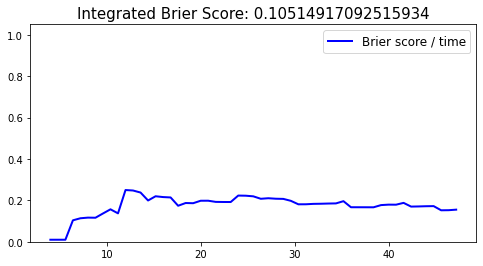

0.6539841849148419


In [ ]:
#dws.losses['State'][-2]
best_state = deepcopy(l_mtlr.losses['State'])
print(l_mtlr.model.load_state_dict(best_state), np.min(l_mtlr.losses['Test']))

_, _, survival = l_mtlr.predict(X_test.values)
lmtlr_predictions = np.squeeze(survival)
print(lmtlr_predictions.shape)

brier_res, ibs, figure = l_mtlr.b_index(X_train.values, T_train, E_train, X_test.values, T_test, E_test, plot=True)
figure.show()
c_index = l_mtlr.c_index(X_test.values, T_test, E_test)
print(c_index)

In [ ]:
from pysurvival.models.non_parametric import KaplanMeierModel

kmf = KaplanMeierModel()
kmf.fit(T_test, E_test)

T = torch.FloatTensor(dws.times[:,np.newaxis,np.newaxis])
mix = Categorical(pi)
comp = Weibull(alpha, beta, validate_args=None)
pdf = torch.sum(MixtureSameFamily(mix, comp).log_prob(T).exp(), (1,2)).data.numpy()

l = []
N = T_test.shape[0]
for i in dws.times:
    l.append(N*kmf.predict_density(i))

fig = go.Figure()
fig.add_trace(go.Scatter(x=dws.times, y=pdf, mode='lines', name='predicted'))
fig.add_trace(go.Scatter(x=dws.times, y=l,mode='lines',name='actual'))
fig.show()

In [ ]:
from sklearn_pandas import DataFrameMapper 
import torchtuples as tt # Some useful functions

from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv


num_durations = 100
labtrans = DeepHitSingle.label_transform(num_durations)
get_target = lambda df: (df[time_column].values, df[event_column].values)
y_train = labtrans.fit_transform(*get_target(data_train))
y_val = labtrans.transform(*get_target(data_valid))

train = (X_train.values.astype(np.float32), y_train)
val = (X_valid.values.astype(np.float32), y_val)

in_features = X_train.shape[1]
num_nodes = [150, 220, 260, 220, 160]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.5

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)
batch_size = 256
#y_train[0] = y_train[0].astype(np.float32)
lr_finder = model.lr_finder(X_train.values.astype(np.float32), y_train, batch_size, tolerance=3)

model.optimizer.set_lr(0.002)
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(X_train.values.astype(np.float32), y_train, batch_size, epochs, callbacks, val_data=val)
cox_surv = model.predict_surv_df(X_test.values.astype(np.float32))
cox_surv

0:	[0s / 0s],		train_loss: 1.0179,	val_loss: 0.9740
1:	[0s / 0s],		train_loss: 1.0048,	val_loss: 0.9741
2:	[0s / 0s],		train_loss: 0.9948,	val_loss: 0.9720
3:	[0s / 0s],		train_loss: 1.0099,	val_loss: 0.9687
4:	[0s / 0s],		train_loss: 0.9868,	val_loss: 0.9625
5:	[0s / 0s],		train_loss: 0.9876,	val_loss: 0.9544
6:	[0s / 0s],		train_loss: 0.9902,	val_loss: 0.9461
7:	[0s / 0s],		train_loss: 0.9811,	val_loss: 0.9400
8:	[0s / 0s],		train_loss: 0.9622,	val_loss: 0.9371
9:	[0s / 0s],		train_loss: 0.9564,	val_loss: 0.9342
10:	[0s / 0s],		train_loss: 0.9668,	val_loss: 0.9306
11:	[0s / 0s],		train_loss: 0.9493,	val_loss: 0.9267
12:	[0s / 0s],		train_loss: 0.9511,	val_loss: 0.9223
13:	[0s / 0s],		train_loss: 0.9206,	val_loss: 0.9167
14:	[0s / 0s],		train_loss: 0.9497,	val_loss: 0.9089
15:	[0s / 0s],		train_loss: 0.9226,	val_loss: 0.9018
16:	[0s / 0s],		train_loss: 0.9037,	val_loss: 0.8952
17:	[0s / 0s],		train_loss: 0.9144,	val_loss: 0.8865
18:	[0s / 0s],		train_loss: 0.9101,	val_loss: 0.8780
19:

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0.000000,0.996228,0.989780,0.996394,0.997704,0.997524,0.994426,0.996858,0.997089,0.995566,0.996020,0.996638,0.998106,0.997376,0.997314,0.997395,0.990308,0.992238,0.996371,0.997485,0.991753,0.996462,0.994476,0.997329,0.986200,0.986545,0.996052,0.998004,0.994640,0.996810,0.995951,0.995316,0.992656,0.996961,0.990052,0.995598,0.988578,0.996538,0.994756,0.995656,0.995635,...,0.990564,0.994146,0.997548,0.997070,0.995102,0.993475,0.994504,0.993707,0.995223,0.996583,0.996894,0.997159,0.996170,0.996255,0.997079,0.996154,0.997257,0.996763,0.996605,0.997045,0.997191,0.992304,0.996787,0.996857,0.996050,0.996864,0.996881,0.997019,0.988981,0.993893,0.993985,0.995365,0.996804,0.994029,0.994182,0.993982,0.996713,0.997296,0.996050,0.996784
0.727273,0.992699,0.983692,0.993719,0.996069,0.995218,0.990114,0.993871,0.994693,0.991402,0.992844,0.993699,0.996642,0.995067,0.995175,0.994923,0.984760,0.985734,0.993467,0.995276,0.982876,0.992776,0.988134,0.994841,0.974371,0.974241,0.993258,0.996413,0.990609,0.994141,0.992757,0.991866,0.988658,0.993335,0.981601,0.992066,0.979999,0.993613,0.990686,0.991785,0.991991,...,0.984410,0.988813,0.995068,0.994553,0.990317,0.988686,0.989192,0.988932,0.991010,0.993682,0.994329,0.995321,0.993455,0.992779,0.994280,0.992546,0.995329,0.993988,0.994172,0.994547,0.995057,0.986068,0.994248,0.994394,0.992895,0.994027,0.994031,0.994154,0.982020,0.989680,0.988676,0.990620,0.993957,0.989181,0.989668,0.988839,0.993298,0.995254,0.991776,0.993581
1.454545,0.989394,0.978642,0.990918,0.993941,0.992462,0.985072,0.990526,0.991276,0.987397,0.988453,0.990545,0.994608,0.992412,0.992779,0.992253,0.976133,0.981324,0.989801,0.992532,0.975645,0.988883,0.982996,0.992031,0.966390,0.968416,0.989786,0.993671,0.986832,0.991222,0.989414,0.987706,0.984625,0.990987,0.975776,0.988410,0.973896,0.989867,0.986085,0.987482,0.988722,...,0.977460,0.980836,0.991972,0.992134,0.986503,0.983322,0.984440,0.985056,0.987419,0.990785,0.990653,0.992927,0.990227,0.989318,0.990625,0.989455,0.992581,0.991124,0.991373,0.991588,0.991911,0.978739,0.990884,0.991176,0.989501,0.990946,0.991864,0.991594,0.976268,0.984743,0.983475,0.986336,0.990596,0.984301,0.984646,0.984128,0.989647,0.992900,0.988141,0.990449
2.181818,0.986018,0.972488,0.988475,0.992177,0.990294,0.980954,0.987389,0.988445,0.983740,0.985047,0.988171,0.992985,0.989966,0.990508,0.989492,0.968831,0.975766,0.987030,0.990351,0.969358,0.984874,0.978305,0.989220,0.956722,0.962515,0.986799,0.991470,0.982489,0.988340,0.985111,0.983775,0.981130,0.988234,0.970146,0.985218,0.967590,0.986947,0.982263,0.983853,0.985103,...,0.971286,0.975796,0.989770,0.989760,0.982069,0.977639,0.979695,0.981051,0.983841,0.987646,0.988286,0.991118,0.987542,0.985961,0.988392,0.986217,0.990845,0.987881,0.988585,0.989188,0.989390,0.972371,0.988235,0.988348,0.985695,0.988362,0.989489,0.988766,0.970139,0.980460,0.977195,0.981986,0.987925,0.980199,0.980918,0.978458,0.986255,0.990616,0.984960,0.987916
2.909091,0.981380,0.964071,0.986129,0.990029,0.986632,0.978316,0.983945,0.985011,0.977606,0.979801,0.983066,0.990516,0.987515,0.988303,0.987433,0.963273,0.968397,0.984744,0.988063,0.961913,0.980554,0.966060,0.986995,0.951687,0.951220,0.982842,0.988770,0.979909,0.985449,0.981638,0.980701,0.974978,0.982036,0.963833,0.982276,0.961953,0.983726,0.976281,0.981048,0.982246,...,0.967377,0.971209,0.987546,0.987088,0.978657,0.974799,0.974263,0.974474,0.979706,0.984441,0.983931,0.988285,0.984973,0.982562,0.984155,0.983341,0.988140,0.985271,0.985623,0.985998,0.985611,0.968533,0.984965,0.985233,0.983444,0.986105,0.984056,0.986005,0.966547,0.977995,0.973385,0.975488,0.983765,0.977037,0.972882,0.975998,0.982750,0.987989,0.979161,0.985487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

0.2133180852178545
0.6193522184993401


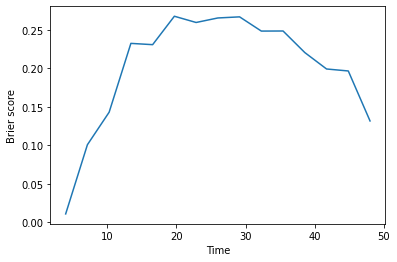

In [ ]:
from pycox.evaluation import EvalSurv
ev = EvalSurv(pd.DataFrame(cox_surv), T_test.values, E_test.values, censor_surv='km')
'''ev.concordance_td()#, ev.integrated_brier_score(dws.times) '''
durations_test, events_test = get_target(data_test)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 15)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')
print(ev.integrated_brier_score(time_grid) )
print(ev.concordance_td('adj_antolini'))

0.21771985499448238
0.7135115240125901


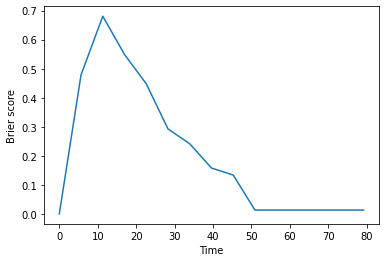

In [ ]:
ev = EvalSurv(pd.DataFrame(survival_predictions), T_test.values, E_test.values, censor_surv='km')
'''ev.concordance_td()#, ev.integrated_brier_score(dws.times) '''
time_grid = dws.times
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')
print(ev.integrated_brier_score(time_grid) )
print(ev.concordance_td('adj_antolini'))

C-index: 0.85


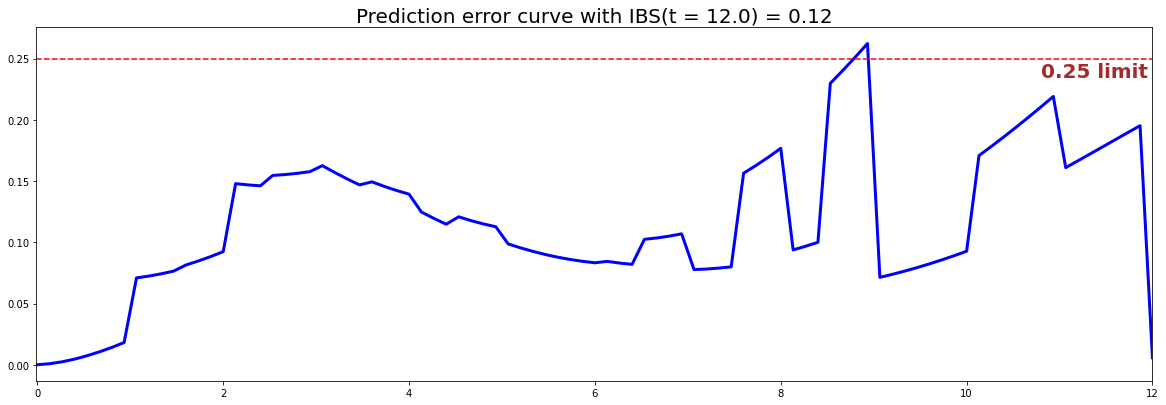

IBS: 0.12
(600, 100)


In [ ]:
from pysurvival.models.parametric import GompertzModel, WeibullModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score

gomp_model = GompertzModel()
gomp_model.fit(X_train, T_train, E_train, lr=1e-2, init_method='zeros',
    optimizer ='adam', l2_reg = 1e-3, num_epochs=2000)


#### 5 - Cross Validation / Model Performances
c_index = concordance_index(gomp_model, X_test, T_test, E_test) #0.77
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(gomp_model, X_test, T_test, E_test,
            figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

gomp_survival = gomp_model.predict_survival(X_test.values)
print(gomp_survival.shape)

In [ ]:
data_test.loc[(data_test[event_column]==1) & (data_test[time_column]>=7) & (data_test[time_column]<=8)].index.values

array([  2,  70, 371])

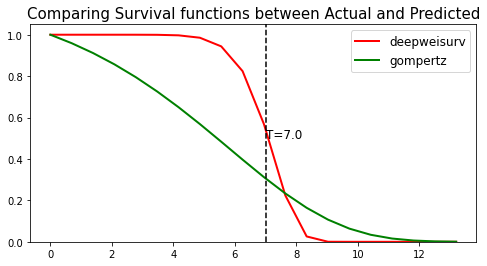

In [ ]:
k = 371
t = T_test[k]
l_predicted = survival_predictions[:,k]
#cox_pred = cox_surv.iloc[:, k].values.flatten()
gomp_predicted = gomp_survival[k].flatten()
#custome_lmt = survival[k].flatten()
''' = lmtlr.predict_survival(X_test.iloc[[k]].values).flatten()
nmtlr_predicted = n_mtlr.predict_survival(X_test.iloc[[k]].values).flatten()'''

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(dws.times, l_predicted.flatten(), color='red', label='deepweisurv', lw=2)
#plt.plot(cox_surv.index, cox_pred, color='blue', label='deephit', lw=2)
'''plt.plot(lmtlr.times, pys_predicted, color='blue', label='pysurvival', lw=2)
plt.plot(n_mtlr.times, nmtlr_predicted, color='green', label='pysurvival nmtlr', lw=2)'''
plt.plot(gomp_model.times, gomp_predicted, color='green', label='gompertz', lw=2)
#plt.plot(l_mtlr.times, custome_lmt, color='black', label='custome mt', lw=2)


plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=12)
'''plt.axvline(x=mlt[k], color='red', ls ='-')
ax.annotate('MLT={:.1f}'.format(mlt[k]), xy=(mlt[k], 0.5), xytext=(mlt[k], 0.9), fontsize=12)'''

# Show everything
title = "Comparing Survival functions between Actual and Predicted"
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()
# the probability that an individual within the population will survive longer than time t.
#Survival Function defines the probability that the event of interest has not occurred at time t 

In [ ]:
dws.times

array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ,
        8.8,  9.6, 10.4, 11.2, 12. , 12.8, 13.6, 14.4, 15.2, 16. , 16.8,
       17.6, 18.4, 19.2, 20. , 20.8, 21.6, 22.4, 23.2, 24. , 24.8, 25.6,
       26.4, 27.2, 28. , 28.8, 29.6, 30.4, 31.2, 32. , 32.8, 33.6, 34.4,
       35.2, 36. , 36.8, 37.6, 38.4, 39.2, 40. , 40.8, 41.6, 42.4, 43.2,
       44. , 44.8, 45.6, 46.4, 47.2, 48. , 48.8, 49.6, 50.4, 51.2, 52. ,
       52.8, 53.6, 54.4, 55.2, 56. , 56.8, 57.6, 58.4, 59.2, 60. , 60.8,
       61.6, 62.4, 63.2, 64. , 64.8, 65.6, 66.4, 67.2, 68. , 68.8, 69.6,
       70.4, 71.2, 72. , 72.8, 73.6, 74.4, 75.2, 76. , 76.8, 77.6, 78.4,
       79.2])

In [ ]:
result = dws.feature_importance(10, X_test.values, T_test.values, E_test.values, batch_size=None)
fig = go.Figure()
# Use x instead of y argument for horizontal plot
for i in range(X_test.shape[1]):
    fig.add_trace(go.Box(x=result['importances'][:,i], name=X_test.columns[i]))

fig.show()

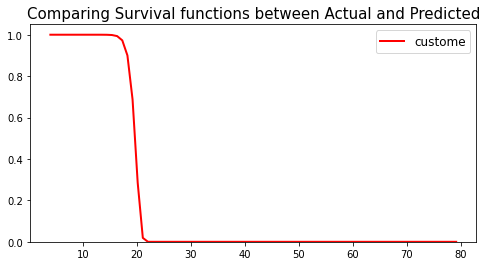

In [ ]:
d = torch.distributions.weibull.Weibull(20, 25, validate_args=None)
t = np.linspace(4,79.2,80)
surv = 1 - d.cdf(t)

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(t, surv.data.numpy().flatten(), color='red', label='custome', lw=2)


# Show everything
title = "Comparing Survival functions between Actual and Predicted"
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()
# the probability that an individual within the population will survive longer than time t.
#Survival Function defines the probability that the event of interest has not occurred at time t 

In [ ]:
d = Weibull(torch.tensor([[1.0, 3.3],[46.3, 119.21]]), torch.tensor([[5.0, 9.45], [45.8, 177.85]]), validate_args=None)
t = np.linspace(4,79.2,2)
t = t[:,np.newaxis]
d.log_prob(t)

In [ ]:
t

array([[ 4. ],
       [79.2]])

In [ ]:
d = Weibull(46.3, 45.8, validate_args=None)
t = np.linspace(4,79.2,2)
t = t[:,np.newaxis]
d.log_prob(79.2)

tensor(-4.7643e+10)

In [ ]:
from torch.distributions.independent import Independent

mix = Categorical(torch.tensor([[0.1, 0.40, 0.5], [0.5, 0.30, 0.2], [0.7, 0.25, 0.05], [0.8, 0.10, 0.1]]))
comp = Weibull(torch.tensor([[1.0, 3.3, 10.24],[46.3, 119.21, 11.54],[11.3, 32.21, 7.54],[90.3, 14.21, 71.54]]), 
               torch.tensor([[5.0, 9.45, 45.6], [45.8, 177.85, 250.6],[29.3, 37.21, 55.54],[101.3, 302.21, 70.54]]), validate_args=None)
mw = MixtureSameFamily(mix, comp)
t = torch.tensor(np.linspace(4,79.2,6)[:,np.newaxis,np.newaxis])
#t = t[:,np.newaxis]
mw.log_prob(t)

tensor([[[-4.3977e+00, -1.1041e+02, -2.8793e+01, -2.0287e+02]],

        [[-2.5023e+06, -4.0513e+01, -2.0279e+01, -9.4368e+01]],

        [[-4.5972e+07, -1.4432e+01, -7.3639e+00, -5.3884e+01]],

        [[-2.8595e+08, -1.3053e+01, -6.5976e+06, -2.8463e+01]],

        [[-1.0872e+09, -1.1036e+02, -1.3676e+11, -9.8884e+00]],

        [[-3.1162e+09, -7.3120e+01, -3.4612e+14, -1.3264e+01]]],
       dtype=torch.float64)

In [ ]:
from google.colab import files
times = pd.DataFrame(dws.times)
times.to_csv('dws_times.csv')
files.download('dws_times.csv')

surv = pd.DataFrame(survival_predictions.T)
surv.to_csv('dws_risk_pred.csv')
files.download('dws_risk_pred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>